# Equity Model

The goal of this notebook is to develop a model for fast equity inference for a texas hold'em preflop scenario.

In [1]:
import itertools
import joblib
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import ensemble
from sklearn import pipeline

sys.path.insert(1, '..')
from bluff.holdem import equity

# Generate Data

Data will be generated using the *Monte Carlo* procedure.

In [2]:
range_ = np.arange(0.0, 100, 1)
n_times = 10000

## Training Data

In [3]:
%%time

prod = itertools.product(range_, range_)

train = pd.DataFrame()

for h, v in prod:
    
    # Get hand from ranking.
    hero_hand = equity.percentage_descr(h)

    # Calculate equity agains villain range.
    eq = equity.eval_ranges(hero_hand, [v], times=n_times)
    
    train = train.append({"Hero": h, "Villain": v, "Equity": eq[0]}, ignore_index=True)
    
train.to_csv(r"linear_model_train.csv")
train.head()

Wall time: 5h 54min 30s


,Equity,Hero,Villain
0,0.500025,0.0,0.0
1,0.611096,0.0,1.0
2,0.683710,0.0,2.0
3,0.747952,0.0,3.0
4,0.772380,0.0,4.0


In [4]:
%%time

test_size = 0.25

test = pd.DataFrame()
for _ in range(int(train.shape[0] * test_size)):
    
    # Choose randomly hero and villain ranges.
    h = np.random.random() * 100
    hero_hand = equity.percentage_descr(h)
    v = np.random.random() * 100
    
    # Calculate equity agains villain range.
    eq = equity.eval_ranges(hero_hand, [v], times=n_times)
    
    test = test.append({"Hero": h, "Villain": v, "Equity": eq[0]}, ignore_index=True)
    
test.to_csv(r"linear_model_test.csv")
test.head()

Wall time: 1h 24min 42s


,Equity,Hero,Villain
0,0.572304,28.720835,59.610942
1,0.712708,9.770339,87.098527
2,0.559839,58.522753,85.593735
3,0.709760,3.879980,30.046708
4,0.826676,0.826672,94.416744


## Testing Data

In [5]:
x_train = train[["Hero", "Villain"]]
y_train = train[["Equity"]]

x_test = test[["Hero", "Villain"]]
y_test = test[["Equity"]]

# Fit Model

In [6]:
pipe = pipeline.Pipeline(
    [
        ("random forest", ensemble.RandomForestRegressor(
            n_estimators=100, 
            max_depth=8,
        )),
    ]
)

pipe.fit(x_train, y_train.values.ravel())
pipe.score(x_test, y_test)

0.9619586153439249

# Visualize Model Predictions

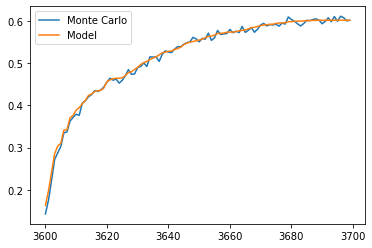

In [19]:
train["Predicted Equity"] = pipe.predict(x_train)

temp = train[train["Hero"] == np.random.choice(train["Hero"])]

plt.plot(temp["Equity"], label="Monte Carlo")
plt.plot(temp["Predicted Equity"], label="Model")
plt.legend()

# Save Model

In [8]:
joblib.dump(pipe, 'equity_model.pkl') 

['equity_model.pkl']